In [ ]:
# File: kershnet1_v.ipynb
# Created: March 2019
# Last Updated: April 2019
# POC: mlwinterrose@gmail.com
# Description: Predict Clayton Kershaw's next pitch based on 
#              11 years of historical Kershaw data, which 
#              includes game state, count in the at-bat, . . . 

### Y. Imports

In [1]:
# Jupyter
%matplotlib inline

# Data manipulation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data prep for ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ML algos
from sklearn.decomposition import PCA

# ML models
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

# ML model evaluation
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Model interpretation
import shap
shap.initjs() # "print the JS viz code to the notebook"

# Misc
#warnings.filterwarnings("ignore")
import time ## directory and file labels
import os                                                              

/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


### Y. Data Ingest

In [2]:
data_path = './data/df_kershaw_statcast_2008thru2018.csv'
df = pd.read_csv(data_path)
#print(df.shape)
#print(df.columns)
#df.head(2)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Y. Data Cleaning

In [3]:
def select_features(df_in, feature_list_in):
    """
        Select a subset of features from which to build a 
        predictive model.
    """
    df_out = df_in[feature_list_in]
    return df_out


def remove_nans(df_in, col_list):
    """
        Deletes rows in df_in that contain NaNs in the columns in col_list
    """
    df_out = df_in.dropna(subset=[col_list])
    return df_out

def select_pitch_type_target(df_in, target_pitch_in):
    """
        Tags the pitch type given in 'target_pitch_in' as '1', 
        and all other pitch types as '0', in preparation
        for binary classification step
    """
    ### turn pitch_type into binary (to start with). Just: is FF or is not:
    df_out = df_in.copy()
    df_out['pitch_bin'] = 0
    # df_out.loc[df_out.pitch_type == 'FF', 'FF_bin'] = 1
    df_out.loc[df_out.pitch_type == target_pitch_in, 'pitch_bin'] = 1
    return df_out

In [4]:
# Parameters for data selection
feature_list = ['pitch_type', 'balls', 'strikes', 'game_year', 
                'batter', 'pitch_number', 'at_bat_number', 
                'home_score','away_score', 'if_fielding_alignment',
                'of_fielding_alignment', 'on_3b', 'on_2b', 'on_1b', 
                'outs_when_up' 
               ]
remove_nans_from_cols = 'pitch_type'
target_pitch_class = 'FF' #'CH' #'CU' #'SL' #'FF' #'SL' #'CU' #'FF' #'CU' #'FF'
test_size = 0.3
nan_strategy = 'fill_zero'

In [5]:
df = select_features(df, feature_list)
df = remove_nans(df, remove_nans_from_cols) ## a hack . . . 
df = select_pitch_type_target(df, target_pitch_class)

### Y. EDA

In [6]:
print(df.columns)
df.head(2)

Index(['pitch_type', 'balls', 'strikes', 'game_year', 'batter', 'pitch_number',
       'at_bat_number', 'home_score', 'away_score', 'if_fielding_alignment',
       'of_fielding_alignment', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up',
       'pitch_bin'],
      dtype='object')


,pitch_type,balls,strikes,game_year,batter,pitch_number,at_bat_number,home_score,away_score,if_fielding_alignment,of_fielding_alignment,on_3b,on_2b,on_1b,outs_when_up,pitch_bin
0,FF,2,1,2018,456034.0,4,48,1,4,Standard,Standard,NaN,571788.0,646240.0,2,1
1,FF,1,1,2018,456034.0,3,48,1,4,Standard,Standard,NaN,571788.0,646240.0,2,1


In [7]:
df['pitch_bin'].value_counts()

1    19965
0    14037
Name: pitch_bin, dtype: int64

In [8]:
df['pitch_type'].value_counts()

FF    19965
SL     8381
CU     4653
CH      795
FT       92
IN       80
FC       35
UN        1
Name: pitch_type, dtype: int64

### viz what type of pitch kersh throws in what type of count

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


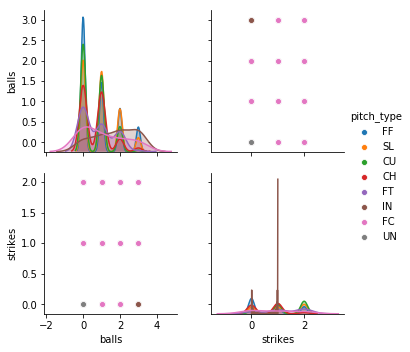

In [9]:
sns.pairplot(df[['balls','strikes','pitch_type']], hue='pitch_type')

#### new NB, viz or EDA kersh data . . . 

### Y. Feature Engineering

### Y. Prepare data for ML

In [10]:
## num_train0, num_train1, frac_class1 = calc_class_imbal(y_train)

def calc_class_imbal(y_in):
    """
    Insert Function Description
    """
    df_ytrain = pd.DataFrame(y_in)
    df_ytrain.columns = ['y']
    df_y_0 = df_ytrain[df_ytrain['y'] == 0]
    df_y_1 = df_ytrain[df_ytrain['y'] == 1]
    num_train0_out = df_y_0.shape[0]
    num_train1_out = df_y_1.shape[0]
    frac_0 = num_train0_out / num_train1_out
    print(" ")
    print('num_train0_out: ', num_train0_out)
    print('num_train1_out: ', num_train1_out)
    print('frac_0: (num_train0_out / num_train1_out): ', frac_0)
    return frac_0

def standardize_data(X_train_in, X_test_in):
    """
    Insert Function Description
    """
    sc = StandardScaler()
    sc.fit(X_train_in)
    X_train_std_out = sc.transform(X_train_in)
    X_test_std_out = sc.transform(X_test_in)
    return X_train_std_out, X_test_std_out

def pca_dim_red(X_train_in, X_test_in):
    
    pca = PCA(n_components=2)
    X_train_pca_out = pca.fit_transform(X_train_in)
    pca.fit_transform(X_train_in)
    X_test_pca_out = pca.transform(X_test_in)
    
    return X_train_pca_out, X_test_pca_out

def create_X_y_dfs(df_in): 
    """
        Hard coded for this specific dataset (generalize later)
    """
    df_y_out = pd.DataFrame(df_in['pitch_bin'])
    df_X_out = df_in.drop(columns=['pitch_type', 'pitch_bin'], axis=1)
    return df_X_out, df_y_out

def create_numeric_and_onehot_features(df_in):
    """
    Insert Function Description
    """    
    df_out = pd.get_dummies(df_in)
    return df_out

def handle_nans(df_in, nan_strategy_in):
    """
    Insert Function Description
    """   
    df_out = df_in
    if (nan_strategy_in == 'fill_zero'):
        df_out = df_in.fillna(0)
    return df_out

def create_ml_data_splits(df_X_in, df_y_in, test_size_in):
    """
    Insert Function Description
    """
    X = df_X_in.values
    y = df_y_in.values
    X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X, y, test_size=test_size, 
                                                                        stratify=y) # random_state=1
    return X_train_out, X_test_out, y_train_out, y_test_out

In [11]:
test_size = 0.3
nan_strategy = 'fill_zero'

In [12]:
df_X, df_y = create_X_y_dfs(df)
df_X = create_numeric_and_onehot_features(df_X)
df_X = handle_nans(df_X, nan_strategy)

X_train, X_test, y_train, y_test = create_ml_data_splits(df_X, df_y, test_size) 
frac_class0 = calc_class_imbal(y_train)

X_train_std, X_test_std = standardize_data(X_train, X_test)
X_train_pca, X_test_pca = pca_dim_red(X_train_std, X_test_std)

 
num_train0_out:  9826
num_train1_out:  13975
frac_0: (num_train0_out / num_train1_out):  0.7031127012522361


### Y. ML Models

In [15]:
def eval_ml_model(label, y_test_in, y_pred_in):
    """
    Evaluate maching learning (ML) model, binary classification
    """
    print(label)
    print(" ")
    
    score_accuracy = accuracy_score(y_test_in, y_pred_in)
    score_precision = precision_score(y_test_in, y_pred_in)
    score_recall = recall_score(y_test_in, y_pred_in)
    score_f1 = f1_score(y_test_in, y_pred_in)
    score_roc_auc = roc_auc_score(y_test_in, y_pred_in)
    score_confmat = confusion_matrix(y_test_in, y_pred_in)
    
    print('Accuracy: ', score_accuracy)
    print('Precision: ', score_precision)
    print('Recall: ', score_recall)
    print('F1: ', score_f1)
    print('ROC_AUC:', score_roc_auc)
    print(score_confmat)
    viz_confusion_matrix(score_confmat)
    print(" ")

In [16]:
def viz_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    # plt.savefig('./figures/confusion_matrix.png', dpi=300)
    plt.show()

In [17]:
# viz_roc(X_train, y_train, X_test, y_test, clf_tree_base)

def viz_roc(X_train, y_train, X_test, y_test, clf):
    
    """
    This code is not (apparently) out of date. Update it to modern later . . . 
    
    . . . yup, sebastian book 2E has updated code on roc viz . . . dig in on this later
    
    . . . so later, do get into skopt and others, definitely . . . and also let's get 
    a roc code up (and maybe see if can do a new decision region code? . . . ) (or can
    just note that new book code (updated) is there and move into other things (skopt) later)
    (now: eat and routine and sleep. fun w/ sabrm reads . . . ).
    """
    
    from sklearn.metrics import roc_curve, auc ## move up when done
    from scipy import interp ## move up when done
    #from sklearn.cross_validation import StratifiedKFold
    from sklearn.model_selection import StratifiedKFold
    
    #cv = StratifiedKFold(y_train, n_folds=5, random_state=1)
    #cv = StratifiedKFold(n_splits=5)
        
    fig = plt.figure(figsize=(7, 5))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    
    for i, (train, test) in enumerate(cv):
        #pdb.set_trace()
        #probas = tree.fit(X_train[train],
        #                     y_train[train]).predict_proba(X_train[test])
            
        probas = tree.fit(X_train[train], list(y_train[train])).predict_proba(X_train[test])

            
        fpr, tpr, thresholds = roc_curve(list(y_train[test]),
                                         probas[:, 1],
                                         pos_label=1)
        #probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test]) fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1],pos_label=1)
        #print(i)
            
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        #plt.plot(fpr, 
        #         tpr, 
        #         lw=1, 
        #         label='ROC fold %d (area = %0.2f)' 
        #                % (i+1, roc_auc))
        
    plt.plot([0, 1], 
             [0, 1], 
             linestyle='--', 
             color=(0.6, 0.6, 0.6), 
             label='Random Guessing')
        
    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Detector Performance (AUC = %0.2f)' % mean_auc, lw=2, color='red')
        
    #  label='Frequency Representation (AUC = %0.2f)' % mean_auc, lw=2, color='red')
        
    #label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
    #plt.plot([0, 0, 1], 
    # [0, 1, 1], 
    # lw=2, 
    # linestyle=':', 
    # color='black', 
    # label='perfect performance')
        
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    #plt.ylabel('true positive rate')
    plt.ylabel('Attack Detection Rate')
    #plt.title('Receiver Operator Characteristic')
    plt.legend(loc="lower right")
        
    plt.tight_layout()
    # plt.savefig('./figures/roc.png', dpi=300)
    plt.show()    

In [18]:
def viz_2d_dec_bnd(X_in, y_in, clf_in, test_idx=None, resolution=0.02):
    """
    Purpose is just to give a viz sense of what algo learning.
    Working in 2D, hparams not optimized to 2D, etc. 
    Just gives a sense of it . . . 
    
    (this function not working without crashing yet . . . return to . . . )
    """
    
    X = X_in
    y = y_in
    
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    #X_test_pca = pca.transform(X_test_in)
    
    clf_in.fit(X_pca, y)    
    
    ### (from sebastian book, think . . . )
    from matplotlib.colors import ListedColormap
    import matplotlib.pyplot as plt
    import numpy as np
    
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    #Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = clf_in.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],alpha=0.8, c=cmap(idx),marker=markers[idx], label=cl)
    # highlight test samples
    if test_idx:
        #print("I'm in!!!")
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', alpha=1.0, linewidths=1, marker='o',s=55, label='test set')
    ###

In [19]:
def plot_decision_regions(X, y, classifier,test_idx=None, resolution=0.02):
    # setup marker generator and color map
    
    from matplotlib.colors import ListedColormap
    import matplotlib.pyplot as plt
    import numpy as np
    
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],alpha=0.8, c=cmap(idx),marker=markers[idx], label=cl)
    # highlight test samples
    if test_idx:
        #print("I'm in!!!")
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', alpha=1.0, linewidths=1, marker='o',s=55, label='test set')


### Y. Tree Hyper Tuning

Baseline
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Classification Tree, Params: Default, Pitch: FF
 
Accuracy:  0.5857268895206352
Precision:  0.6502555366269165
Recall:  0.637228714524207
F1:  0.6436762225969646
ROC_AUC: 0.574848030973811
[[2158 2053]
 [2173 3817]]


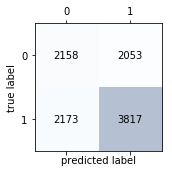

In [20]:
print('Baseline')

clf_tree_base = []
clf_tree_base = tree.DecisionTreeClassifier()

print(clf_tree_base)

# viz_2d_dec_bnd(X_train, y_train, clf_tree_base) # not working yet. return to.
# viz_roc(X_train, y_train, X_test, y_test, clf_tree_base) # ok. my act roc_viz code is too out of date . . . 
                                                           # start over on it later . . . modernize
clf_tree_base.fit(X_train, y_train)
y_pred_tree_base = []
y_pred_tree_base = clf_tree_base.predict(X_test)
eval_ml_model('Classification Tree, Params: Default, Pitch: ' + target_pitch_class, y_test, y_pred_tree_base)

In [21]:
n_iter_in = 10

Hyper Tuned !
best_score_ :  0.666610646611487
best_params_ : {'min_samples_split': 0.2, 'max_depth': 11.0}
Tree, Params: Grid1, Pitch: FF
 
Accuracy:  0.6613077149299088
Precision:  0.6889253241913847
Recall:  0.771619365609349
F1:  0.7279313331758406
ROC_AUC: 0.6380063106840381
[[2124 2087]
 [1368 4622]]


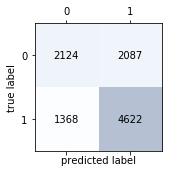

NameError: name 'df_best_params' is not defined

In [22]:
print('Hyper Tuned !')

clf = []
clf = tree.DecisionTreeClassifier()

hparams = {}
hparams['max_depth'] = np.linspace(1,32,32, endpoint=True) # alone: auc=0.6536 (best just on own)
hparams['min_samples_split'] = np.linspace(0.1, 1.0, 10, endpoint=True)
#hparams['min_samples_leaf'] = np.linspace(0.1, 0.5, 5, endpoint=True)
#hparams['max_features'] = list(range(1,X_train.shape[1]))

clf_best = GridSearchCV(clf, hparams, cv=5, verbose=0)

clf_best = RandomizedSearchCV(clf, hparams,
                              n_iter=n_iter_in, cv=5, verbose=0) # n_iter=100 #random_state=1

clf_best.fit(X_train, y_train)

# print("scorer_ : ", clf_best.scorer_) # scorer_ :  <function _passthrough_scorer at 0x1a24d7d378>
print("best_score_ : ", clf_best.best_score_)
print("best_params_ :", clf_best.best_params_)

y_pred1 = clf_best.predict(X_test)

eval_ml_model('Tree, Params: Grid1, Pitch: ' + target_pitch_class, y_test, y_pred1)

df_clf_best = pd.DataFrame(clf_best.cv_results_) ## awesome. this is perfect !!!

#df_clf_best.to_csv('hparams_decTree_randomCV_budg' + 
#                   str(n_iter_in) + '_' + str(round(time.time())) + 
#                   '.csv')

# probably belongs in it's own function .  . 
timestamp_out = str(round(time.time()))
directory_out_name = 'data_out_dectree_' + timestamp_out
os.mkdir(directory_out_name)

#df_best_params = pd.DataFrame({'hparams':hparams,
#                               'n_iter':n_iter_in,
#                               'best_score': clf_best.best_score_,
#                               'best_params': clf_best.best_params_
#                              })

#df_best_params.to_csv('/' + directory_out_name + '/' +
#                      'best_params_decTree_randomCV_budg' + 
#                      str(n_iter_in) + '_' + str(round(time.time())) + 
#                      '.csv')

df_best_params.to_csv(directory_out_name + '/' +
                      'best_params_decTree_randomCV_budg' + 
                      str(n_iter_in) + '_' + str(round(time.time())) + 
                      '.csv')

df_best_params = pd.DataFrame({'hparams':hparams,
                               'n_iter':n_iter_in,
                               'best_score': clf_best.best_score_,
                               'best_params': clf_best.best_params_
                              })

df_clf_best.to_csv(directory_out_name + '/' +
                   'hparams_decTree_randomCV_budg' + 
                   str(n_iter_in) + '_' + str(round(time.time())) + 
                   '.csv')

In [ ]:
! pwd

In [ ]:
#hparams

In [ ]:
str(round(time.time()))

In [ ]:
# Figure out csv creation to track hyper_param tuning . . . 

# useful: https://stackoverflow.com/questions/34274598/does-gridsearchcv-store-all-the-scores-for-all-parameter-combinations

#clf_best.cv_results_ #nice

#clf_best.cv_results_['mean_test_score'] #nice

#clf_best.cv_results_.keys()

In [24]:
df_clf_best = pd.DataFrame(clf_best.cv_results_) ## awesome. this is perfect !!!

In [25]:
print(df_clf_best.shape)
print(df_clf_best.columns)
df_clf_best.head(2)

(10, 15)
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_min_samples_split', 'param_max_depth', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010896,0.001742,0.001131,0.000122,0.9,1,"{'min_samples_split': 0.9, 'max_depth': 1.0}",0.613317,0.603571,0.606303,0.597899,0.592857,0.602790,0.007019,4
1,0.018576,0.001889,0.000807,0.000037,0.2,11,"{'min_samples_split': 0.2, 'max_depth': 11.0}",0.685990,0.670378,0.662395,0.660504,0.653782,0.666611,0.011041,1


In [ ]:
df_clf_best.to_csv('df_clf_best_lookAt1.csv')

### Y. XGB Hyper Tuning

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

scorer_ :  <function _passthrough_scorer at 0x1a1d0fe510>
best_score_ :  0.682786437544641
best_params_ : {'max_depth': 4, 'num_estimators': 50}
XGBoost, Params: Grid1, Pitch: FF
 
Accuracy:  0.68130575433781
Precision:  0.7144199154532644
Recall:  0.7617696160267112
F1:  0.7373353801405833
ROC_AUC: 0.6643091727723202
[[2387 1824]
 [1427 4563]]


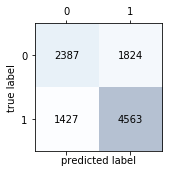

In [42]:
clf = xgb.XGBClassifier()
    
hparams = {}
#hparams['num_estimators'] = [50, 100, 150, 200]
hparams['num_estimators'] = [50, 100]
#hparams['max_depth'] = [4,6,8,10]
hparams['max_depth'] = [4,8]
    
#clf.fit(X_train_in, y_train_in)
    
clf_best = GridSearchCV(clf, hparams, cv=5, verbose=0)
clf_best.fit(X_train, y_train)

print("scorer_ : ", clf_best.scorer_)
print("best_score_ : ", clf_best.best_score_)
print("best_params_ :", clf_best.best_params_)

y_pred_xgb_grid1 = clf_best.predict(X_test)
    
#print('Target Pitch: ', target_pitch_in)

eval_ml_model('XGBoost, Params: Grid1, Pitch: ' + target_pitch_class, y_test, y_pred_xgb_grid1)

see. that is a reasonable amount of time . . . why is SKOPT SO slow ?

(run it and go eat . . . see if skopt ever stops . . . )

In [ ]:
df_clf_best_xgb_grid1 = pd.DataFrame(clf_best.cv_results_)
#clf_best
#clf_best.cv_results_

In [ ]:
df_clf_best_xgb_grid1

In [ ]:
help(GridSearchCV)

In [ ]:
clf = xgb.XGBClassifier()
    
hparams = {}
#hparams['num_estimators'] = [50, 100, 150, 200]
hparams['num_estimators'] = [50, 100]
#hparams['max_depth'] = [4,6,8,10]
hparams['max_depth'] = [4,8]

    
#clf.fit(X_train_in, y_train_in)
    
#clf_best = GridSearchCV(clf, hparams, cv=5, verbose=0)
clf_best = RandomizedSearchCV(clf, hparams, random_state=1,
                              n_iter=10, cv=5, verbose=0) # n_iter=100

clf_best.fit(X_train, y_train)

print("best_score_ : ", clf_best.best_score_)
print("best_params_ :", clf_best.best_params_)

    
y_pred_xgb_rand1 = clf_best.predict(X_test)
    
#print('Target Pitch: ', target_pitch_in)

eval_ml_model('XGBoost, Params: Rand1, Pitch: ' + target_pitch_class, y_test, y_pred_xgb_rand1)

df_clf_best_xgb_rand1 = pd.DataFrame(clf_best.cv_results_)

In [ ]:
print(df_clf_best_xgb_rand1.shape)
df_clf_best_xgb_rand1.head(3)

In [ ]:
clf = xgb.XGBClassifier()
    
hparams = {}
#hparams['num_estimators'] = [50, 100, 150, 200]

#hparams['num_estimators'] = [50, 100]
#hparams['num_estimators'] = [50, 51]
hparams['num_estimators'] = [50]

#hparams['max_depth'] = [4,6,8,10]
#hparams['max_depth'] = [4,8]

#hparams['max_depth'] = [4,5]
hparams['max_depth'] = [4]
    
    
#clf.fit(X_train_in, y_train_in)
    
#clf_best = GridSearchCV(clf, hparams, cv=5, verbose=0)
clf_best = BayesSearchCV(clf, hparams, cv=5, verbose=0) ## will it literally work exactly same if want it to?

clf_best.fit(X_train, y_train)

print("best_score_ : ", clf_best.best_score_)
print("best_params_ :", clf_best.best_params_)
    
y_pred_xgb_bayes1 = clf_best.predict(X_test)
    
#print('Target Pitch: ', target_pitch_in)

eval_ml_model('XGBoost, Params: BayesSearchCV1, Pitch: ' + target_pitch_class, y_test, y_pred_xgb_bayes1)

#### 5/20/2019, 2:15am: ok. this one is taking forever . . . study how param supposed to be specified . . . and get them in there right . . . and then und how to get the tuning csv want out (same as sklearn or diff? . . . ).

#### ok. take this up post thing tomm (and then other sh, tons.). Now, go to sleep. asap. GO. 

In [ ]:
#df_clf_best_xgb_rand1 = pd.DataFrame(clf_best.cv_results_)

### Y. Ok. Here we go: 5/25/2019: let's fix parameter input syntax

(using example from: http://localhost:8889/notebooks/Desktop/scikit-optimize-master/examples/sklearn-gridsearchcv-replacement.ipynb)

In [27]:
clf = xgb.XGBClassifier()
    
hparams = {}
#hparams['num_estimators'] = [50, 100, 150, 200]

#hparams['num_estimators'] = [50, 100]
#hparams['num_estimators'] = [50, 51]
#hparams['num_estimators'] = [50]

hparams['num_estimators'] = Integer(50,51)

#hparams['max_depth'] = [4,6,8,10]
#hparams['max_depth'] = [4,8]

#hparams['max_depth'] = [4,5]
#hparams['max_depth'] = [4]
hparams['max_depth'] = Integer(4,5)
    
    
#clf.fit(X_train_in, y_train_in)
    
#clf_best = GridSearchCV(clf, hparams, cv=5, verbose=0)
clf_best = BayesSearchCV(clf, hparams, cv=5, verbose=0) ## will it literally work exactly same if want it to?

clf_best.fit(X_train, y_train)

print("best_score_ : ", clf_best.best_score_)
print("best_params_ :", clf_best.best_params_)
    
y_pred_xgb_bayes1 = clf_best.predict(X_test)
    
#print('Target Pitch: ', target_pitch_in)

eval_ml_model('XGBoost, Params: BayesSearchCV1, Pitch: ' + target_pitch_class, y_test, y_pred_xgb_bayes1)

TypeError: __init__() got an unexpected keyword argument 'fit_params'

### Y. Shap model interpretations

#### "Classic feature attributions"

In [ ]:
#help(xgb.plot_importance)

In [28]:
#plt.plot(figsize=(5,8))
xgb.plot_importance(clf_xgb_base, height=0.2)

NameError: name 'clf_xgb_base' is not defined

#### (work on getting real feature names in there .  .  . can I pass the df into xgboost . . . expt

In [29]:
clf_xgb_base = xgb.XGBClassifier()
#clf_xgb_base.fit(X_train, y_train)
clf_xgb_base.fit(df_X, df_y)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Text(0.5, 1.0, 'xgboost.plot_importance(model)')

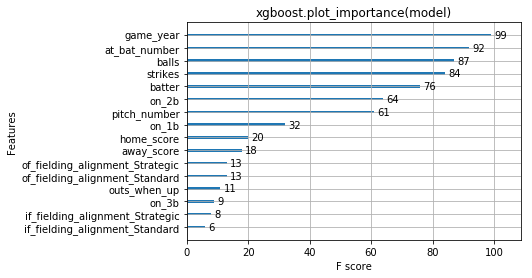

In [30]:
xgb.plot_importance(clf_xgb_base, height=0.2)
plt.title("xgboost.plot_importance(model)")

#### (cool. it worked . . . just pass the df into xgboost . . . and then the plots are perfect . . . note, need to take training/test split, etc, still . . . but later . . . this is perfect for viz now !!!)

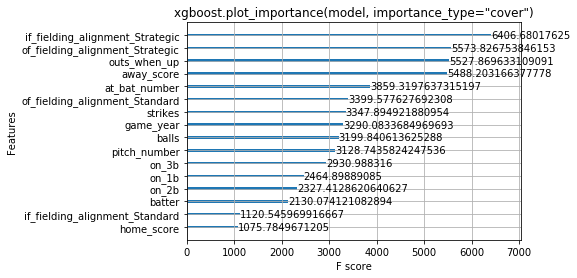

In [31]:
model = clf_xgb_base
xgb.plot_importance(model, importance_type="cover")
plt.title('xgboost.plot_importance(model, importance_type="cover")')
plt.show()

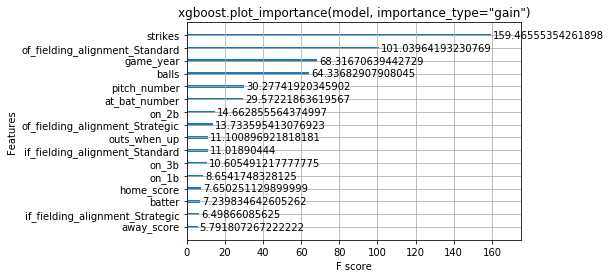

In [32]:
xgb.plot_importance(model, importance_type="gain")
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()

#### (see. inconsistent . . . (get vocab down . . . )

### Y. Explain predictions

("Here we use the Tree SHAP implementation integrated into XGBoost to explain the entire dataset (32561 samples).")

In [33]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(X)
shap_values = explainer.shap_values(df_X)

### Visualize a single prediction
Note that we use the "display values" data frame so we get nice strings instead of category codes.

In [34]:
#shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])
shap.force_plot(explainer.expected_value, shap_values[0,:], df_X.iloc[0,:])

### Visualize many predictions
To keep the browser happy we only visualize 1,000 individuals.

In [35]:
#shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_display.iloc[:1000,:])
shap.force_plot(explainer.expected_value, shap_values[:1000,:], df_X.iloc[:1000,:])

#### wow. beautful. cool !!!

### Bar chart of mean importance
This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

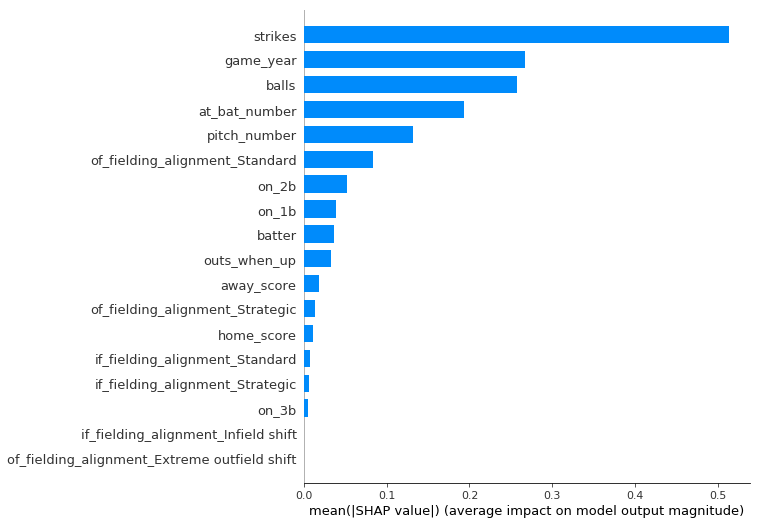

In [36]:
#shap.summary_plot(shap_values, X_display, plot_type="bar")
shap.summary_plot(shap_values, df_X, plot_type="bar")

#### wow . . . this may really be revealing some pitching secrets . . .

### SHAP Summary Plot
Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.
Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

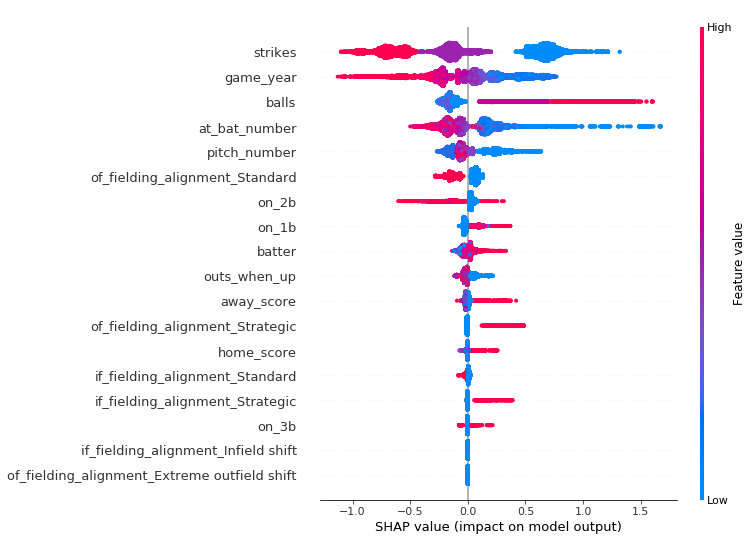

In [37]:
#shap.summary_plot(shap_values, X)
shap.summary_plot(shap_values, df_X)

#### wow. really cool. look at game_year . . . yeah . . . that's exactly right . . . gotta show people this . . . 

#### (can do this by pitch_type . . . and learn tons . . . ) (and also, divide out by year . . . and get more specific insight on other categories . . . )

### SHAP Dependence Plots
SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

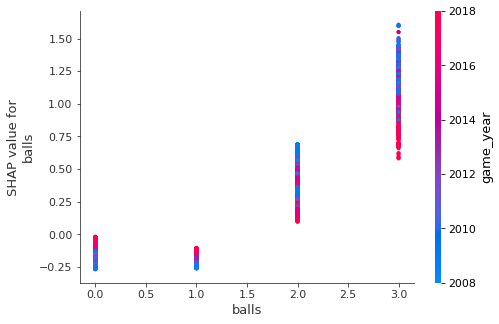

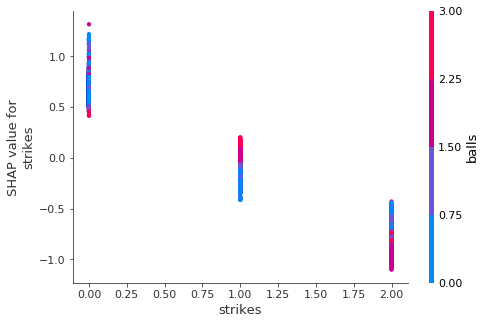

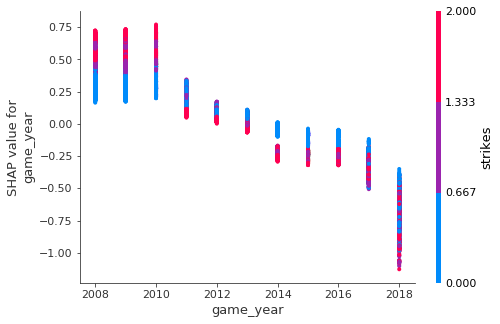

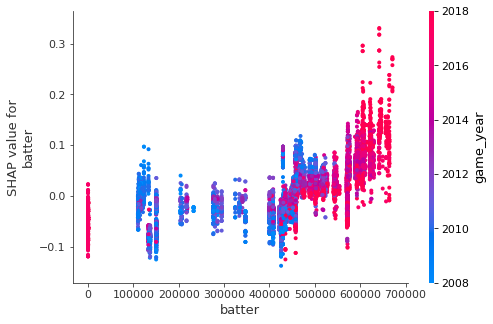

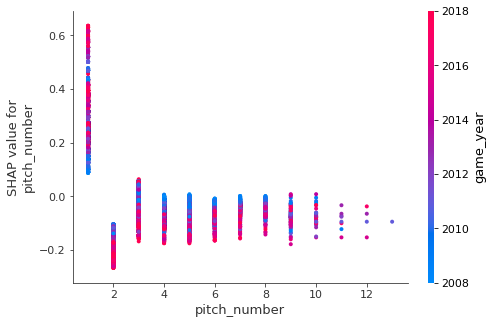

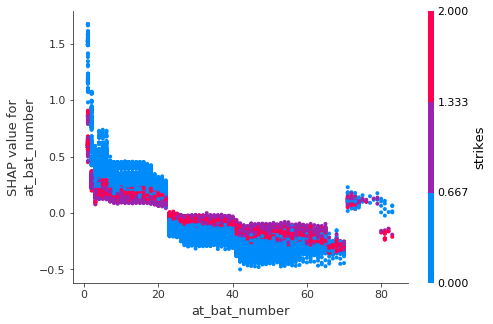

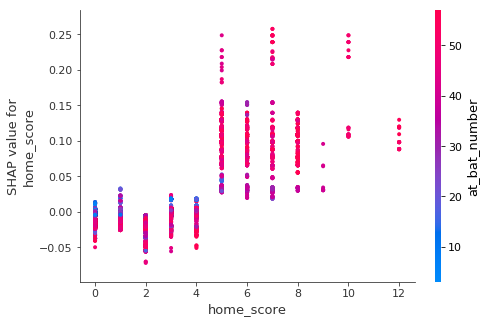

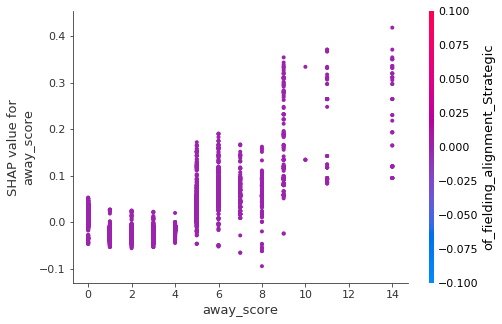

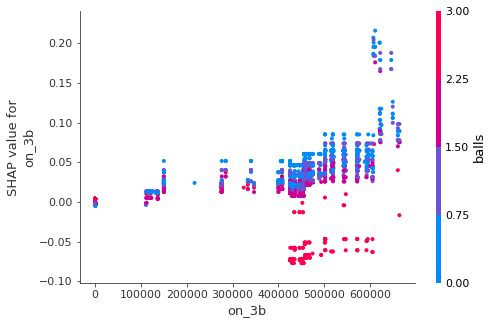

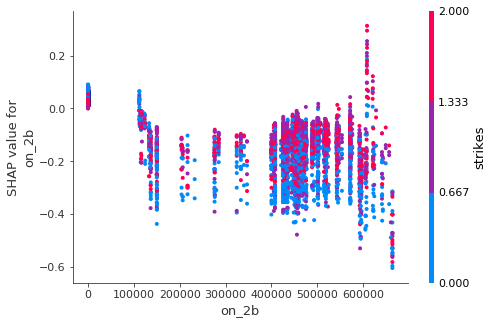

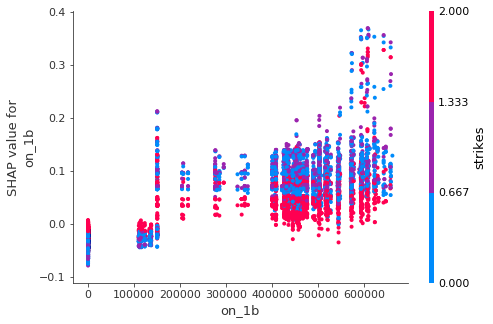

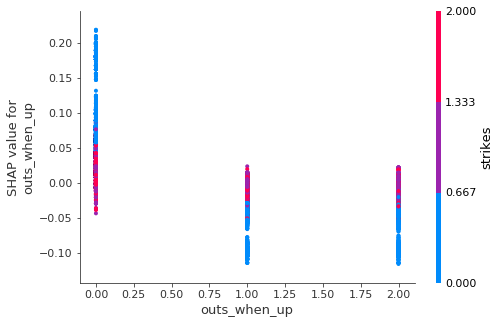

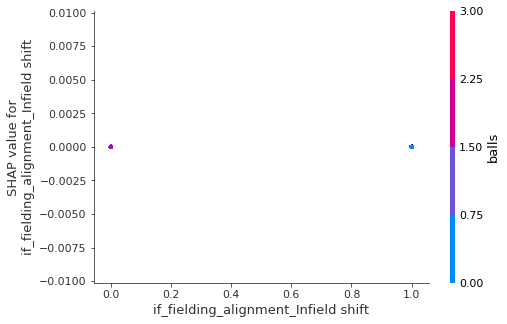

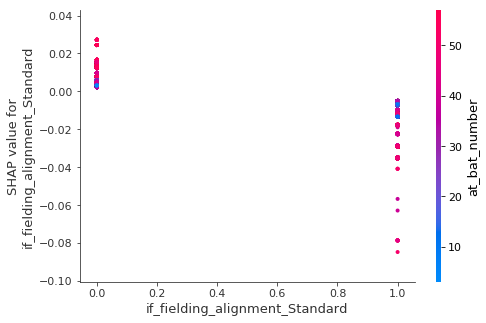

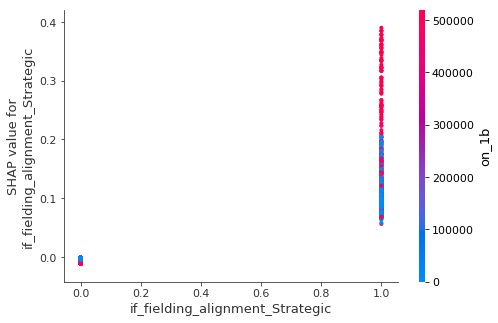

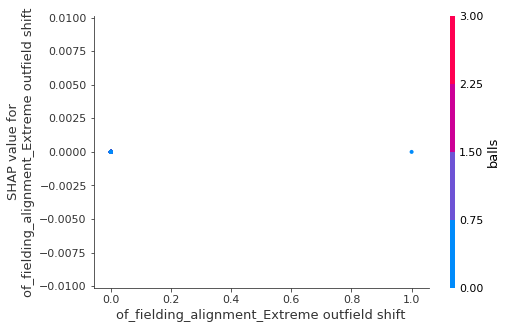

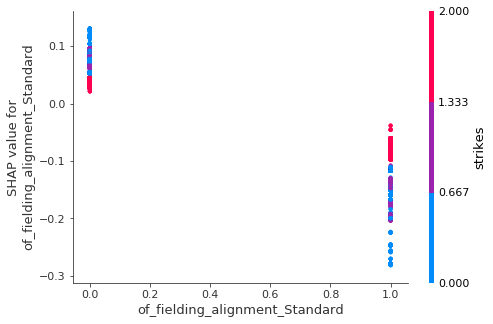

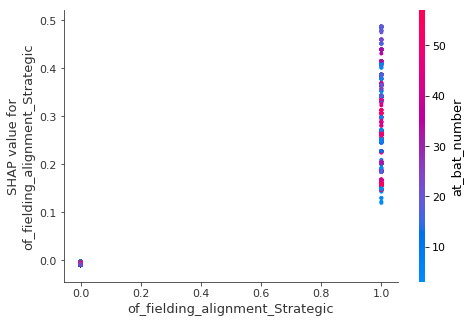

In [38]:
#for name in X_train.columns:
#    shap.dependence_plot(name, shap_values, X, display_features=X_display)

for name in df_X.columns:
    shap.dependence_plot(name, shap_values, df_X, display_features=df_X)

#### (cool. this works . . . just think thru to see what makes most sense to look at for interactions . . . )

##### ok . . . and there is more advanced sh in the example notebook here (not in blg article . . . ).  Take a look as come deeper into this . . . have enough to start with . . . 
https://github.com/slundberg/shap/blob/master/notebooks/tree_explainer/Census%20income%20classification%20with%20XGBoost.ipynb

#### (ok. cool. can tell real stories with this now . . . (and apply overallt in MA as well . . . ). Awesome. Get at this . . . use use use . . .) 

#### (so many ways to slice things and tell deep stories . . . power !!!)

#### (ok. awesome. success. did this. go to bed. morning: call, and org, and go . . . ). 

# get the nice viz stuff from nc days .  . . 

### Y. Viz single trees in boost ensemble . . . 

In [39]:
clf_xgb_base

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# plot_tree(model)
# pyplot.show()
# plot_tree(model, num_trees=4)
# plot_tree(model, num_trees=0, rankdir='LR')

# hange the layout of the graph to be left to right (easier to read) 
#      by changing the rankdir argument as LR (left-to-right) rather 
#      than the default top to bottom (UT).

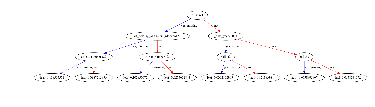

In [40]:
# brownlee xgb book, around pg. 26

xgb.plot_tree(clf_xgb_base) ## crash: ImportError: You must install graphviz to plot tree (at dodger stadium. get this when on web.)

### Y. Lime . . . 

In [ ]:
import shap

In [ ]:
#import lime ## but works from python command line . . . 

##### look. shap is best. do read the blg to und lime. and try it from spyder . . . or from idle . . . but no worry too much tomm on it . . . 